#**Customer Churn Prediction on Sparkify Dataset**


In [1]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing Libraries

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler

from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

#### Creating the Spark Connection

In [4]:
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)
df = spark.read.json("/content/drive/MyDrive/sparkify_dataset.json")

## **Data Visualization**

In [5]:
df.count()

543705

In [6]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
## Number of Distinct Records
df.select('userId').distinct().count()

449

In [9]:
## Number of Distinct Authorizations
df.select('auth').distinct().count()

4

In [10]:
## Number of Distinct Levels
df.select('level').distinct().count()

2

In [11]:
## Number of Distinct gender
df.select('gender').distinct().count()

3

#### Plotting Authentication status vs Number of Users

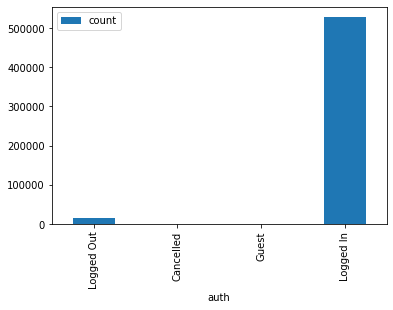

In [12]:
auth_df = df.select('auth').groupBy('auth').count().toPandas()
auth_df.index = auth_df.auth
auth_df.plot.bar()

#### Plotting Subscription Level (free or paid) vs Number of Users

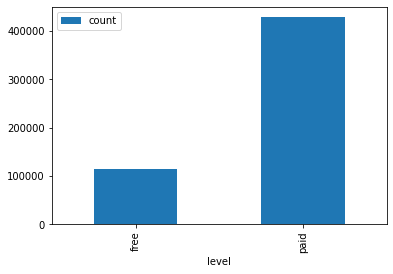

In [13]:
level_df = df.select('level').groupBy('level').count().toPandas()
#level_df.plot.bar()
level_df.index = level_df.level
level_df.plot.bar()

#### Plotting Gender (Female or Male or None) vs Number of Users

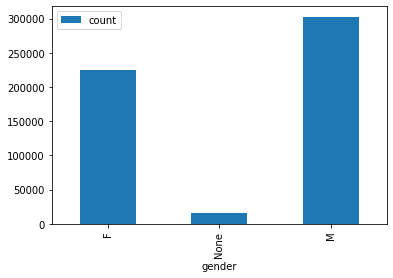

In [14]:
gender_df= df.select('gender').groupBy('gender').count().toPandas()
gender_df.index =gender_df.gender
#gender_df
gender_df.plot.bar()

### **Data Sanity Checks**

In [15]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
#df.select([count(when(isnull(c), c)) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [16]:
df.where("artist is null").show()

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In| Maverick|     M|          185|Santiago|  null| paid|Orlando-Kissimmee...|   PUT|         Logout|1535953455000|      178|null|   307|1538352119000|"Mozilla/5.0 (Mac...|   179|
|  null|Logged Out|     null|  null|          186|    null|  null| paid|                null|   GET|           Home|         null|      178|null|   200|1538352148000|                null|      |
|  null|Logged Out|     n

In [17]:
df.where("lastName is null").show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          186|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352148000|     null|      |
|  null|Logged Out|     null|  null|          187|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352151000|     null|      |
|  null|Logged Out|     null|  null|          188|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352168000|     null|      |
|  null|Logged Out|     null|  nul

# **Data Cleaning & Prepartion**

In [18]:
## Function to Clean the Data
def datacleaning(df):
  for field in df.schema.fields:
        if field.dataType==StringType():
            df = df.withColumn(field.name,regexp_replace(field.name,'[^a-zA-Z0-9\,\-]',''))
              
  df1 = df.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
  df2 = df1.withColumn('month', month(col('interaction_time')))
  #df2
  df3 = df2.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
  df4 = df3.withColumn('userId', col('userId').cast(LongType()))
  df5 = df4.filter(col('userId').isNotNull())
  #print(df5)
  df6 = df5.filter(col('auth')!='LoggedOut')
  df7 = df6.withColumn('location', split(col('location'),',').getItem(1))
  return df7

In [19]:
## Function to label the data
def labelling(df):
    labelling = df.withColumn('label',when((col('page').isin(['Cancellation Confirmation','Cancel'])) | (col('auth')=='Cancelled'),1 ).otherwise(0)).groupby('userId').agg(sum('label').alias('label')).withColumn('label', when(col('label')>=1 ,1).otherwise(0))
    df = df.join(labelling, on='userId')
    #df
    return df

In [20]:
## Function to check the Registred days
def registered_days(df):
    lastused =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))
    df = lastused.join(df, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))
    
    return df

In [21]:
## Function to check the Subscription Level
def latest_level(df):
    lastlevel = df.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('valid_level'))
    df = df.drop('level')
    #df
    df = df.join(lastlevel, on='userId')
    return df

In [22]:
def avglen(df):
    averagelength = df.groupBy('userId').avg('length').withColumnRenamed('avg(length)', 'length')
    df = df.drop('length')
    #print(df)
    df = df.join(averagelength, on='userId')
    return df

In [23]:
## Building a Pipline
def pipeline(num_cols):
    gender =StringIndexer(inputCol='gender', outputCol='gender_index')
    location =StringIndexer(inputCol='location', outputCol='location_index')
    assembler= VectorAssembler(inputCols=num_cols, outputCol='features')
    pipeline= Pipeline(stages=[gender, location, assembler])

    return pipeline

In [24]:
def datapostprocess(features_df):
    num_cols = []
    
    for field in features_df.schema.fields :
        if field.dataType!=StringType():
            num_cols.append(field.name)
            #print(nums_cols)

    num_cols.remove('label')

    pipeline2 = pipeline(num_cols)
    model2 = pipeline2.fit(features_df).transform(features_df)
    #type(model_df)
    return model2

In [25]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# Main Function
# Function to Predict
# We are using 3 models i.e. Logistic Regression , Random Forest and Gradient Boosting
def predictionfunction(train, test, model):
    #logistic Regression Model
    if model == 'Logistic-Regression':
        ml = LogisticRegression()
    #Random Forest Model
    elif model == 'Random-Forest':
        ml = RandomForestClassifier()
    # Gradient Boosting Model
    elif model == 'Gradient-Boost':
        ml = GBTClassifier()
    else:
        return "Model not valid"
    
    clf = ml.fit(train)
    results = clf.transform(test)
    modeleval(results)
    return clf, results

In [26]:
## Function to evaluate the Model
from sklearn import metrics
def modeleval(results):
    f1_score= MulticlassClassificationEvaluator(metricName='f1')
    f1_score2= f1_score.evaluate(results.select(col('label'), col('prediction')))
    #modelsumm=metrics.classification_report(test,results.select(col('label'), col('prediction')))
    #print("The summary of the model", modelsumm)
    print('The F1 score on the test set is {:.2%}'.format(f1_score2)) 
    

In [27]:
def sessionduration(df):
    daily = df.groupby('userId','date','sessionId').agg(max('ts').alias('session_end'), min('ts').alias('session_start')).withColumn('session_duration_sec', (col('session_end')-col('session_start'))*0.001).groupby('userId','date').avg('session_duration_sec').groupby('userId').agg(mean('avg(session_duration_sec)').alias('avg_daily_session_duration')).orderBy('userId', ascending=False)

    monthly = df.groupby('userId','month','sessionId').agg(max('ts').alias('session_end'), min('ts').alias('session_start')).withColumn('session_duration_sec', (col('session_end')-col('session_start'))*0.001).groupby('userId','month').avg('session_duration_sec').groupby('userId').agg(mean('avg(session_duration_sec)').alias('avg_monthly_session_duration')).orderBy('userId', ascending=False)
    
    return daily.join(monthly, on='userId')

In [28]:
def item_aggregates(df):
    daily2 = df.groupby('userId','date').agg(max('itemInSession')).groupBy('userId').avg('max(itemInSession)').withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
    #daily2
    monthly3 = df.groupby('userId','month').agg(max('itemInSession')).groupBy('userId').avg('max(itemInSession)').withColumnRenamed('avg(max(itemInSession))', 'avg_monthly_items')
    
    return daily2.join(monthly3, on='userId')

In [29]:
def pageevent_dailyormonthly(df):
    
    # Function to calculate the daily averages for each user except the ones that include cancel
    pg_daily_df,exp_dict = daily_pg(df)
    # Function to calculate the monthly averages for each user except the ones that include cancel
    pg_monthly_df = monthly_pg(df,exp_dict)

    return pg_daily_df.join(pg_monthly_df, on='userId')

In [30]:
def daily_pg(df):
    listOfDistinctPages =[row.page for row in df.select('page').distinct().collect()]
    listOfDistinctPages.remove('Cancel')
    listOfDistinctPages.remove('CancellationConfirmation')
    daily_page_event_df = df.groupby('userId','date').pivot('page').count()
    exp_dict={}
    for page in listOfDistinctPages:
        exp_dict.update({page:'mean'})
    daily_page_event_df = daily_page_event_df.join(daily_page_event_df.groupBy('userId').agg(exp_dict).fillna(0), on='userId')

    for page in listOfDistinctPages:
        daily_page_event_df =daily_page_event_df.drop(page)  
        daily_page_event_df= daily_page_event_df.withColumnRenamed('avg({})'.format(page), 'avg_daily_{}'.format(page))

    pg_daily_df = daily_page_event_df.drop('Cancel','CancellationConfirmation','date').drop_duplicates()
    return pg_daily_df,exp_dict

In [31]:
def monthly_pg(df,exp_dict):
    listOfDistinctPages =[row.page for row in df.select('page').distinct().collect()]
    listOfDistinctPages.remove('Cancel')
    listOfDistinctPages.remove('CancellationConfirmation')
    # exp_dict={}
    monthly_page_event_df = df.groupby('userId','month').pivot('page').count()

    monthly_page_event_df = monthly_page_event_df.join(monthly_page_event_df.groupBy('userId').agg(exp_dict).fillna(0), on='userId')
    for page in listOfDistinctPages:
        monthly_page_event_df = monthly_page_event_df.drop(page)    
        monthly_page_event_df = monthly_page_event_df.withColumnRenamed('avg({})'.format(page), 'avg_monthly_{}'.format(page))

    pg_monthly_df = monthly_page_event_df.drop('Cancel','CancellationConfirmation','month').drop_duplicates()
    return pg_monthly_df

In [32]:
# def page1(df):
#   pages_list = [r.page for r in df.select("page")]
#   pages_list.remove('CancellationConfirmation')
#   pages_list.remove('Cancellation')


In [33]:
def mergefeature(df, df_sess_duration, df_item, df_page):

    alljoined =df_sess_duration.join(df_item, on='userId').join(df_page, on='userId')
    #drop the following features
    df = df.drop('auth', 'level','length','userAgent','month','date','interaction_time','registration', 'ts','song','page','itemInSession','sessionId','artist','firstName','lastName','method','status')
    finaljoined = alljoined.join(df, on='userId')
    
    finaljoined2 = finaljoined.drop_duplicates()
    features = finaljoined2.drop('userId')
    
    return features

In [34]:
vali = datacleaning(df)
labell= labelling(vali)
regd= registered_days(labell)
df = latest_level(regd)

In [36]:
df.toJSON("Clean_Sparkify_Data.json")

MapPartitionsRDD[205] at toJavaRDD at NativeMethodAccessorImpl.java:0

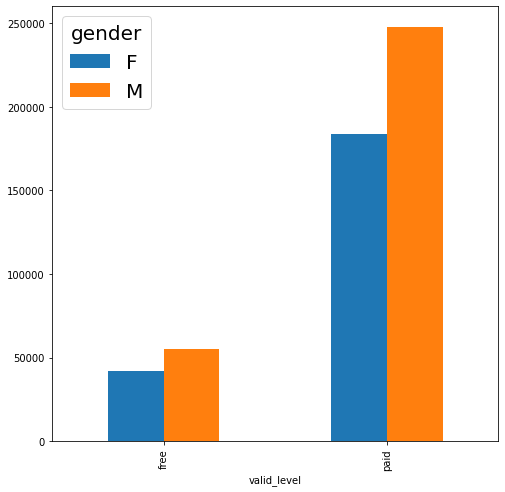

In [37]:
df_count = df.select('userId','gender','valid_level').groupby('gender','valid_level').count().toPandas().sort_values(by='count')
## Plotting Free or Paid Subscription vs Male or Female users
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count.pivot(index='valid_level', columns='gender', values='count').plot(kind='bar', ax=ax)

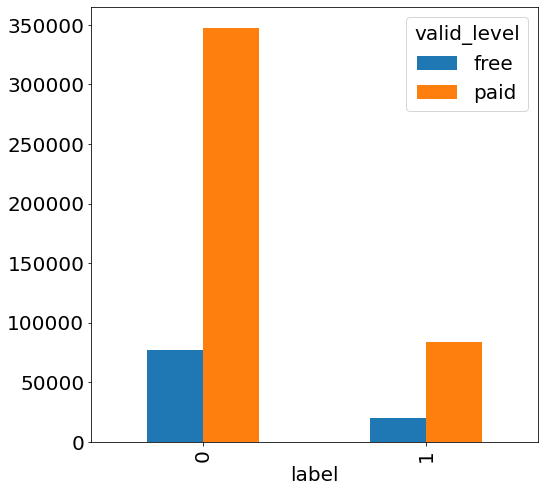

In [38]:
df_count_ = df.select('userId','valid_level','label').groupby('valid_level','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count_.pivot(index='label', columns='valid_level', values='count').plot(kind='bar', ax=ax)

In [39]:
df = avglen(df)
session =sessionduration(df)
aggri =item_aggregates(df)
#df_item
page= pageevent_dailyormonthly(df)
#print(df_page)


In [40]:
df = mergefeature(df,session,aggri,page)

In [41]:
df.show()

+--------------------------+----------------------------+------------------+-----------------+--------------------+------------------+-------------------+------------------+---------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------------+----------------------+-------------------+-----------------------+------------------+-------------------------+----------------------+--------------------+---------------------+--------------------+-----------------+-----------------+-------------------+----------------+------------------+-------------------------+----------------------+--------------------+------------------------+---------------------+-------------------------+----------------+---------------------------+----------------+------+-----------+-----+---------------+-----------+
|avg_daily_session_duration|avg_monthly_session_duration|   avg_daily_items|avg_monthly_items|avg_daily_RollAdvert|avg_da

# **Data Modeling**

In [42]:
finalmodeldata = datapostprocess(df)

In [43]:
## Spliting data into 70-30 Ratio (i.e. 70% Train Dataset, 30% Test Dataset with sandom seed=69)
X_train, X_test = finalmodeldata.randomSplit([0.7, 0.3], seed=69)

In [44]:
# for model in ['logistic_regression','random_forest','gradient_boosting']:
#     predictionfunction(train, test, model)

In [45]:
model1='Logistic-Regression'
predictionfunction(X_train,X_test,model1)

model2='Random-Forest'
predictionfunction(X_train,X_test,model2)

model3='Gradient-Boost'
predictionfunction(X_train,X_test,model3)


The F1 score on the test set is 85.29%
The F1 score on the test set is 83.28%
The F1 score on the test set is 88.55%


(GBTClassificationModel: uid = GBTClassifier_649c4f10a0ad, numTrees=20, numClasses=2, numFeatures=40,
 DataFrame[avg_daily_session_duration: double, avg_monthly_session_duration: double, avg_daily_items: double, avg_monthly_items: double, avg_daily_RollAdvert: double, avg_daily_Settings: double, avg_daily_Downgrade: double, avg_daily_NextSong: double, avg_daily_Error: double, avg_daily_About: double, avg_daily_Upgrade: double, avg_daily_Home: double, avg_daily_Logout: double, avg_daily_AddtoPlaylist: double, avg_daily_ThumbsDown: double, avg_daily_ThumbsUp: double, avg_daily_SaveSettings: double, avg_daily_AddFriend: double, avg_daily_SubmitUpgrade: double, avg_daily_Help: double, avg_daily_SubmitDowngrade: double, avg_monthly_RollAdvert: double, avg_monthly_Settings: double, avg_monthly_Downgrade: double, avg_monthly_NextSong: double, avg_monthly_Error: double, avg_monthly_About: double, avg_monthly_Upgrade: double, avg_monthly_Home: double, avg_monthly_Logout: double, avg_monthly_Add